# loading_model.ipynb

Recently in class, we've been talking about _massive_ models. For instance, ResNet-152 has over 60 million parameters, and Google's JFT-300M was trained on 300 million images. For a two week project, training models comparable to these would be just a little difficult. Training some of these models takes millions of dollars, so instead of trying to dig into specific models, architectures, and datasets, I will go through how to load and apply these models. In this notebook, I'll load a model (squeezenet 1.0) and explore passing a few inputs to it, which is closer to a real world example of how to use these models. This notebook is not about the specific model. The procedure would work on other, bigger models. I chose squeezenet because it is a relatively small model that performs well, and I think we will talk about it sometime soon in class. Throughout, I mess around with some downloaded images. The original images can be found in the directory.


I'll also start exploring the model as a black-box function, trying to find how to break it. In doing this, I'll create a few images with added noise. I'll design this noise to fool the model. Here's a sneak peak of how the image classification model can be tricked:


![image](./spoiler.png)


The left image is classified as an Irish Water spaniel, the middle is classified as a goldfish, and the right is neither. The results of the two left images should worry you! In the last section I go over how I made these images.


## Loading the Model

Some of this is from [PyTorch's tutorials on loading models](https://pytorch.org/vision/stable/models.html), combined with [documentation for squeezenet on PyTorch](https://pytorch.org/hub/pytorch_vision_squeezenet/). I'm mostly just combining these resources and using my own images here, not much original coding.

I have a few images commented out below that I experimented with while writing the first half of this notebook. I also tried with an image of a person, but the preprocessing step (shown later) kept rotating the image, and I'm still not sure why. I could not get that image to work as an example, which goes to show that this process is not without its difficulties.

In [402]:
import torch
from torchvision.models import squeezenet1_0
from PIL import Image
from torchvision import transforms

filename = 'dog.jpg'
# filename = 'scuba.jpg'
# filename = 'fish.jfif'
input_image = Image.open(filename)

We set the model to `eval`, which does more than just disable the gradient. This also removes training features such as dropout. The preprocess transform is specific to the model and is based on what they did for training. In short, this `preprocess` transformation resizes the image to a $256 \times 256$ image, performs a very slight crop, converts to a tensor type, and normalizes the RGB channels. We show an example output of this, but in short the image is still reasonable. To show the example, we need to swap around the dimensions of the tensor with `permute` for `matplotlib`. We also grab the probabilities predicted by the model for all $1000$ classes that the model predicts for. The input image is an Italian Waterdog, which is not one of the $1000$ classes that the model can predict.

The original image is not of size $256 \times 256$ like the original training images. The image might not even be square. This was one big worry I had about doing this project, but it turns out that it is very easy to resize images using PyTorch. We might create some weird stretching if our original image is too rectangular, but that's a separate discussion.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


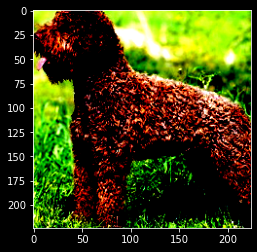

In [403]:
import matplotlib.pyplot as plt
model = squeezenet1_0(pretrained=True)
model.eval()

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
plt.imshow(input_tensor.permute(1, 2, 0))
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

with torch.no_grad():
    output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

So at this point, `probabilities` is a vector with `1000` elements, corresponding to the `1000` classes of ImageNet. However, we don't know which entries correspond to what classes. We need the names associated with the class number.

From [here](https://gist.githubusercontent.com/maraoz/388eddec39d60c6d52d4/raw/791d5b370e4e31a4e9058d49005be4888ca98472/gistfile1.txt), we can download a text file that includes all 1000 classes and names. I still had to modify this a bit to get everything to work properly (e.g. removing single quotes, adding quotes for all the numbers, etc). I'm thankful I know how to use `CTRL + f` and how to do multiline editing. This code creates `classes` as a list so that the class names share the same index as the `probabilities` tensor.

In [404]:
import json
with open('classes.txt') as f:
    data = f.read()

js = json.loads(data)
classes = list(js.values())

For the image above, let's look at the top 5 predicted classes and their associated probabilities.

In [405]:
(vals,inds) = torch.topk(probabilities,k=5)
inds_list = [int(indi) for indi in inds]
top_k_classes = [classes[ind] for ind in inds_list]
print(top_k_classes)
print(vals)

['Irish water spaniel', 'miniature poodle', 'standard poodle', 'curly-coated retriever', 'Kerry blue terrier']
tensor([0.8127, 0.0679, 0.0643, 0.0252, 0.0238])


Googling "Irish water spaniel", this doesn't seem too far off from an Italian water dog. This does illustrate another point about using models in more realistic settings. _Not all the data will even have a correct answer_. For instance, all of the testing and training images fell into one of the 1000 possible classes, but we are asking the model to classify an image beyond those categories.

For a while, the above was not working, and I was getting random classes with very low probabilities. I decided to look at the probabilities associated with all the classes (not just the top 5). I compared these to a uniform distribution over the classes and found that the model's predicted probability distribution was fairly close to the uniform distribution. It turns out that I was loading an untrained version of the model. I fixed my code above to properly load a pretrained model, which simplified the model loading process quite a bit. Now we see that there are some preferred classes, and the distribution approaches a delta distribution, where one class will hold all of the probability. This is how the model should behave for a good prediction.

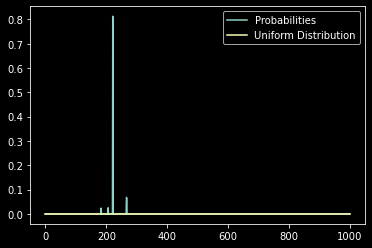

In [406]:
plt.plot(probabilities)
plt.plot([0,999],[1.0/1000]*2)
plt.legend(('Probabilities','Uniform Distribution'))

Below, I write a function that loads a desired image, and outputs the top 5 predictions, along with a display of the image. This is a helpful function to have if we are looking at a bunch of images. I also load in the two other images I have been experimenting with.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['Irish water spaniel', 'miniature poodle', 'standard poodle', 'curly-coated retriever', 'Kerry blue terrier']
tensor([0.8127, 0.0679, 0.0643, 0.0252, 0.0238])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['scuba diver', 'snorkel', 'sea snake', 'reel', 'hook, claw']
tensor([9.7768e-01, 2.1176e-02, 4.4492e-04, 1.2500e-04, 7.2400e-05])
['goldfish, Carassius auratus', 'tench, Tinca tinca', 'axolotl, mud puppy, Ambystoma mexicanum', 'rock beauty, Holocanthus tricolor', 'puffer, pufferfish, blowfish, globefish']
tensor([8.4190e-01, 1.5612e-01, 8.2926e-04, 3.2393e-04, 1.6669e-04])


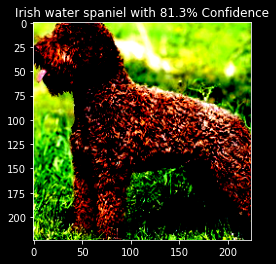

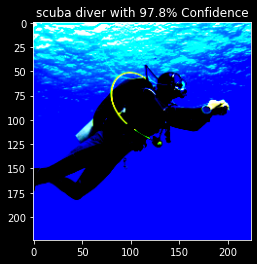

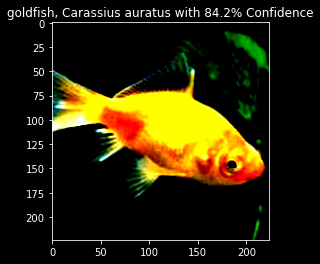

In [407]:
def get_readable_output(model, classes, filename):
    input_image = Image.open(filename)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # if torch.cuda.is_available():
    #     input_batch = input_batch.to('cuda')
    #     model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    (vals,inds) = torch.topk(probabilities,k=5)
    inds_list = [int(indi) for indi in inds]
    top_k_classes = [classes[ind] for ind in inds_list]
    print(top_k_classes)
    print(vals)
    plt.figure()
    plt.imshow(input_tensor.permute(1, 2, 0))
    plt.title(f'{top_k_classes[0]} with {vals[0]*100:.1f}% Confidence')
    
filename = 'dog.jpg'
get_readable_output(model,classes,filename)
get_readable_output(model,classes,'scuba.jpg')
get_readable_output(model,classes,'fish.jfif')

## Let's try and trick it. Let's use some weird animals.

In class, we talked about data augmentation. Specifically, we talked about Mixup and CutMix, where two or more images are combined to give an input image. This input image then has labels that are weighted by the percent that each of these combined images was used to create the final image. In my opinion, this is not fully correct. If you take a region from an image of a cat and use it to replace the corresponding region on an image of a dog, sure you have some combination of a dog and a cat. But, if the image has 60% of dog pixels and 40% of cat pixels, a human likely would not say that the image is 60% a dog, and 40% a cat. However, that is how the model is being trained. There are two reasons that the human would not answer like the model:

1. Some pixels are more important than other pixels. If you replace just the head of the dog image with the head of the cat image, humans will say that the image is more like a cat. As humans, we use certain features to identify things. We are very good at identifying faces. Thus, the human identifier would weight the importance of matching the head/face of an animal more than the model would. The model would be trained to just count how many pixels there are, but the human has a prior assumption that the pixels associated with a head or a face are more important.
2. A human identifier could easily just choose one of the possible images. For instance, if the tail of a dog is replaced with the tail of a cat, a human may just say that the image is a dog. If the goal is to choose *one correct answer*, humans usually won't bubble in multiple choices.

Nonetheless, from a mathematical point of view, this technique makes sense to regularize the model, helping the optimization find parameters that are more robust to the input images.

Let's look at a Liger. This image is different from actual ligers. In the second version, I just changed the cropping to shift the image to the left.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['lion, king of beasts, Panthera leo', 'Tibetan mastiff', 'tiger, Panthera tigris', 'Leonberg', 'ox']
tensor([0.6559, 0.1581, 0.0467, 0.0289, 0.0219])
['tiger, Panthera tigris', 'tiger cat', 'lion, king of beasts, Panthera leo', 'tabby, tabby cat', 'Leonberg']
tensor([0.4830, 0.1646, 0.0611, 0.0361, 0.0244])


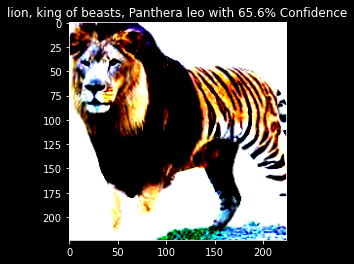

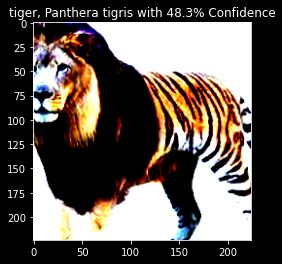

In [408]:
get_readable_output(model,classes,'liger.jfif')
get_readable_output(model,classes,'liger2.jfif')

If I had to choose, I would say that the first image is a lion. As I mentioned before, the face and head of an animal is important and carries more weight. I would rationalize this picture as "a lion with stripes" (a lion nontheless). For the first image, we see that the first three categories make sense. The model is also uncertain, which is a good sign. 
After the first image, I was curious if I could get the model to say that the image was a tiger. I cropped the image, and sent it back through the preprocessing and model analysis. Somehow, by placing the lion's face closer to the edge of the domain drops the probability of lion from 66% to 6%. Nonetheless, this is a trick question, and the model still gives reasonable answers.

Now, I pass in a shark horse combo. There is not even a corresponding class for "horse", which makes this one extra difficult.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['crane', 'American egret, great white heron, Egretta albus', 'spoonbill', 'Saluki, gazelle hound', 'albatross, mollymawk']
tensor([0.1695, 0.1592, 0.1515, 0.1466, 0.1140])


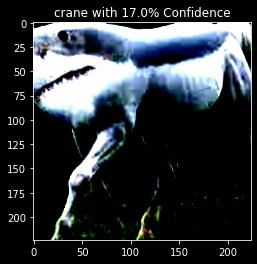

In [409]:
get_readable_output(model,classes,'sharse2.jfif')

The predictions above are worse than for the liger, but they still make a little sense. The image is a shark with horse legs. The shark body is very bulky and big for the relatively thin legs. This is just like all the suggested classes. The birds follow this trend, and so does the gazelle hound. They all have somewhat small legs, and a big body. Also, out of 1000 classes, the top 5 were still all animals, so the model must recognize some features such as the eyes and mouth.

## Create our own images to trick the model

So now, rather than using vizually photoshopped images, we will mathematically alter our images.
We'll use the fish as the base image, because that image is actually part of the dataset. The code below is very similar to what we have seen before. The only difference is now using a parameter `eps` which describes how much noise to add to the image. We center this uniform noise at $0$. Note that by using `rand_like`, we add noise to all 3 color channels, and all of the pixels. We do this _before_ the preprocessing. However, for this preprocessing normalization step, it would not make much of a difference if we were to add the noise after. The `perturbed` tensor/image corresponds to the tensor/image that we get by adding noise to the original.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['goldfish, Carassius auratus', 'tench, Tinca tinca', 'axolotl, mud puppy, Ambystoma mexicanum', 'rock beauty, Holocanthus tricolor', 'eel']
tensor([9.9996e-01, 3.8825e-05, 3.7245e-06, 5.0103e-07, 9.2765e-08])
['goldfish, Carassius auratus', 'agama', 'eel', 'rock beauty, Holocanthus tricolor', 'axolotl, mud puppy, Ambystoma mexicanum']
tensor([0.7270, 0.0857, 0.0658, 0.0561, 0.0260])


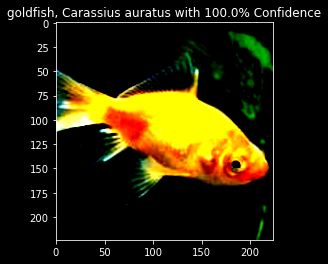

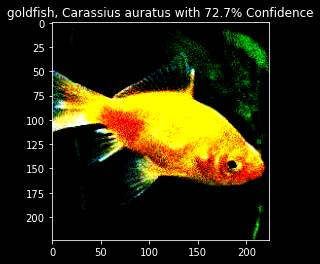

In [410]:
# Break preprocessing into two parts
image_to_tensor = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()])
preprocess_tensor = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

filename = 'fish.jfif'
input_image = Image.open(filename)
input_tensor = preprocess(input_image)

# This is the new part. Add in some noise.
eps = 0.4
noise = eps*(torch.rand_like(input_tensor)-0.5)*2.0
perturbed_tensor = input_tensor + noise

def get_readable_output_from_tensor(input_tensor):
    # This function is just a shortened version of get_readable_output
    # The only difference is that it takes a tensor rather than a filename of an image,
    #  and it outputs a little more information for us to reuse.
    input_batch = preprocess_tensor(input_tensor).unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    (vals,inds) = torch.topk(probabilities,k=5)
    inds_list = [int(indi) for indi in inds]
    top_k_classes = [classes[ind] for ind in inds_list]
    print(top_k_classes)
    print(vals)
    plt.figure()
    plt.imshow(input_tensor.permute(1, 2, 0))
    plt.title(f'{top_k_classes[0]} with {vals[0]*100:.1f}% Confidence')
    return (inds_list[0],probabilities)

# Compare the original and perturbed images.
(current_ind,probabilities) = get_readable_output_from_tensor(input_tensor)
_ = get_readable_output_from_tensor(perturbed_tensor)

Above, we add a perceptible amount of noise, and we see the classifier become less certain in it's prediction. Messing around with this noise level, we can definitely still see that it's a goldfish, but the model quickly starts to fail. However, we can tell a difference between the original and perturbed images and it's understandable that the classifier gets worse when the original image is degraded. However, _can we trick the classifier with the image being unchanged to the human eye_?

This is what we shall explore next.

## Deliberately Tricky Images

Now our goal is to trick the classifier to give us the wrong prediction, without humans being able to to tell the difference in the image.

[This article](https://towardsdatascience.com/how-to-fool-a-neural-network-958ba5d82d8a) describes a procedure for tricking neural networks (or in general differentiable classifiers). I skimmed through the ideas and tried to implement them myself, making some changes based on the performance I saw on this example. The article does not include any code or explicit equations. The overall idea is to let the added noise be a trainable object. In other words, denote the input tensor $x \in \mathbb{R}^{224 \times 224 \times 3}$. Let $\eta$ denote the noise tensor, of the same shape as $x$. The perturbed image is $\tilde{x} = x + \eta$. The goal is to choose $\eta$ to trick the network.

Now, we can get more into the discussion of what "tricking" we really mean. There are two goals we may have:
1. Make the model give a low probability for the correct class.
2. Make the model give a high probability for a different class.

Let the correct class be denoted by the basis vector $e_i \in \mathbb{R}^{1000}$, corresponding to class $i$. In my code, this is `current_ind`. The incorrect class that we will try to get the model to predict is $e_j \in \mathbb{R}^{1000}$ which is a one-hot encoding of class $j$. In my code, this is `goal_ind`, which I chose as the "Irish water spaniel".

In order to find the "trickiest" $\eta$, we will use PyTorch's optimization. We will create a loss function, $L(\eta)$, corresponding to our two objectives listed above. We will need to compute $\frac{\partial L}{\partial \eta}$ to decide how to best update $\eta$. Luckily, the classifier / model is differentiable with respect to the input, so we can compute this with our regular backpropagation. Denote the classifier as $f : \mathbb{R}^{224 \times 224 \times 3} \to \mathbb{R}^{1000}$. The exact details of the loss function took some time to tune, which also complicates the function, so I will just include the general idea. Let $\lambda \in \mathbb{R}$ and $\lambda > 0$.

$$
L(\eta) =  \lambda l_1(\eta) + l_2(\eta)
$$

$$
l_1(\eta) = p(\arg \max_{\{1,2,...,1000\}} f(x + \eta) = i)
$$

$$
l_2(\eta) = -p(\arg \max_{\{1,2,...,1000\}} f(x + \eta) = j)
$$

This is not exactly what is implemented, but it gets the idea across. Instead of working with probabilities, I had better results just working directly with the output of the model (before the `softmax` function is applied to convert into the classes). Using this direct output was probably better, as it is unbounded, rather than stuck between $0$ and $1$ like the probability. We can interchange these without changing the idea as the transformation from unbounded output to the probability is an increasing function. So decreasing the unbounded output will decrease the associated probability. This is a small implementation detail.

Let's look at these two terms separately. First, $l_1$ is the term trying to get the model to predict the wrong class. Thus, we want to minimize the probability that the guess is the correct class (class $i$). If $\arg \max_{\{1,2,...,1000\}} f(x + \eta) = i$, that means that the model correctly guesses the class, so this is what we will want to minimize. Next, $l_2$ is the term trying to promote the false class. We want to maximize the probability of guessing the false class $j$. This is equivalent to minimizing the negative of the probability, so we just replace $i$ with $j$ and negate the expression. Finally, $\lambda$ is a hyperparameter weighting the relative importance of these two tasks. In the code below, I also add in some normalization based on the size of $\eta$. This is to try and get $\eta$ small so that we do not notice that the image has been altered.

Note that we choose the relative size of the noise to be $\varepsilon = 0.01$. We saw before that this parameter weighted how much noise we add to the input.

In [411]:
import numpy as np

# This is the class we want to trick the mdoel to give.
goal_ind = 221

# Keep the probabilities from the unaltered image of the previous block.
prob_current_o = probabilities[current_ind]
prob_goal_o = probabilities[goal_ind]

# Create noise as a trainable parameter, with an associated optimizer.
noise = torch.nn.Parameter(torch.rand_like(input_tensor))
optimizer = torch.optim.Adam([noise],lr=0.01)

# Experiment with some learning rate schedulers. These update the learning rate during training.
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,0.99)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300,0.001)

# Normalization parameter weighting our two objectives
with torch.no_grad():
    lam = probabilities[goal_ind]

# Track losses and our probability of tricking the model into the wrong class.
losses = []
probs = []

epochs = 1000
for i in range(epochs):
    # This is \tilde{x} = x + \eta
    perturbed_tensor = input_tensor + 0.005*noise/(torch.mean(torch.abs(noise)))
    
    # We've seen these steps before
    input_batch = preprocess_tensor(perturbed_tensor).unsqueeze(0)

    output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Another potential loss function that penalizes all classes except for our goal class.
    # loss = -output[0,goal_ind] + torch.mean(output[0,np.arange(1000)!=goal_ind])

    # L = l2 + lam l1
    loss = -output[0,goal_ind] + lam*output[0,current_ind]

    # Track our history during training.
    losses.append(loss.detach().item())
    probs.append(probabilities[goal_ind].detach())

    # Regular optimization steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

Show the training metrics. Remember this is for training the noise to fool the network.

Text(0, 0.5, 'Percent Irish water spaniel')

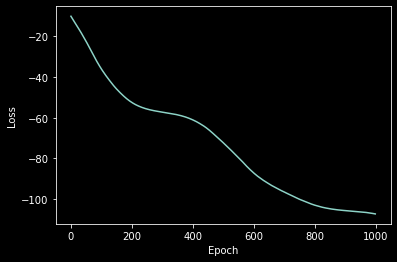

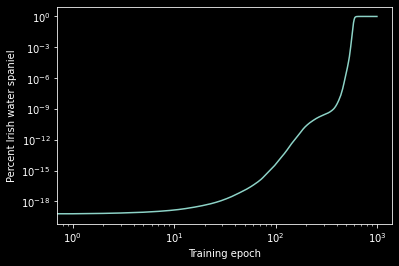

In [412]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.loglog(probs)
plt.xlabel('Training epoch')
plt.ylabel(f'Percent {classes[goal_ind]}')


This is a quick analysis of what happens if we add that noise into the image. There will be more code like this. We multiply the noise by $\varepsilon$ to control how much noise we add. Here, we are adding a relatively high amount. We have seen the rest of the code before.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.2817e-13, grad_fn=<SelectBackward>)


Text(0.5, 1.0, 'bubble with 81.2% Confidence')

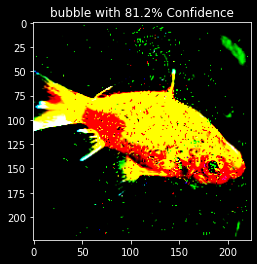

In [413]:
noise_measure = torch.mean(torch.abs(noise.detach()))
eps = 0.05

perturbed_tensor = input_tensor + eps/noise_measure * noise.detach()

input_batch = preprocess_tensor(perturbed_tensor).unsqueeze(0)
output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

(vals,inds) = torch.topk(probabilities,k=5)
inds_list = [int(indi) for indi in inds]
top_k_classes = [classes[ind] for ind in inds_list]

print(probabilities[goal_ind])

plt.figure()
plt.imshow(input_batch.squeeze().permute(1,2,0))
plt.title(f'{top_k_classes[0]} with {vals[0]*100:.1f}% Confidence')


The above gives a pretty distorted image, and the class is not what we were trying to trick the model to do. We will see that this is just too much noise.

Below, we just rewrite the code to give the probability of fooling the model to predict our goal class (Irish water spaniel) and the probability of getting the correct class (goldfish). This probability depends on _how much_ noise we add. In other words, it depends on `eps` / $\varepsilon$.

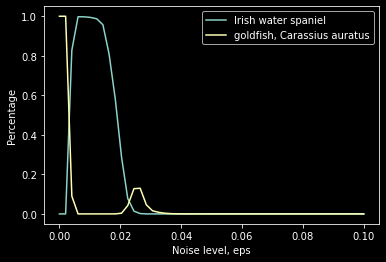

In [ ]:
def get_trickery_percents(eps):
    perturbed_tensor = input_tensor + eps/noise_measure * noise.detach()

    input_batch = preprocess_tensor(perturbed_tensor).unsqueeze(0)
    output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    prob_goal = probabilities[goal_ind]
    prob_current = probabilities[current_ind]
    return (prob_goal, prob_current)

eps = np.linspace(0,0.1)
probs_goal = np.zeros_like(eps)
probs_current = np.zeros_like(eps)

for i,epsi in enumerate(eps):
    (probs_goal[i], probs_current[i]) = get_trickery_percents(epsi)


plt.figure()
plt.plot(eps,probs_goal)
plt.plot(eps,probs_current)
plt.xlabel('Noise level, eps')
plt.ylabel('Probability')
plt.legend((classes[goal_ind],classes[current_ind]))

In the above, we see that with a pretty small noise level $\varepsilon$, we can get the model to predict that the image is not a goldfish. This was our first objective. The second objective was to get the model to predict that the class was "Irish water spaniel". This only happens for a certain range of $\varepsilon$. In other words, if we add too much noise, the model does not even predict this class!  With a large enough $\varepsilon$ the model predicts neither goldfish nor Irish water spaniel. This is extremely surprising, as I viewed the problem as finding the optimum direction to perturb the input. It turns out that not only the direction, but the magnitude of the perturbation matters for this second task. This shows the highly nonlinear nature of the model / loss (for a linear loss, if we chose a direction, the loss function would increase linearly, let alone ever decreasing like we it must here). This is worth taking some time to think about. We will show a further example next.

In class, we've talked about normalizing inputs in a few contexts. We've already done all of these normalizing steps, as they are part of using a model properly, especially if it is pretrained. However, for what we are doing, we also want to go from the normalized input back to a regular image. We do this by applying the inverse of the preprocessing transformation (which includes the normalization). For the normalization, we can do this by using the multiplicative inverse of the standard deviations and then the additivie inverse of the means as shown [here](https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/4) and included below. Other transformations such as cropping are "singular" in the sense that they remove information from the system and they therefore can not be perfectly inverted.

Again, this is almost all code we have seen before. We just apply the inverse of the normalization so the images do not look as weird. We'll show some example images of the goldfish with added noise, compared to the original goldfish. In these images, we will include the probabilites we are trying to manipulate (goldfish and Irish water spaniel).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'eps = 0.03 \n Irish water spaniel: 1.19e-03%, \n goldfish, Carassius auratus: 2.10%')

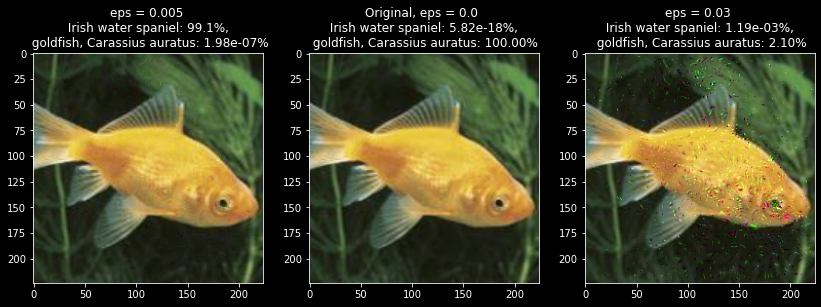

In [417]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)
# Forgive the non-modular coding, this should probably be a function
#  as I've written something similar a few times, but I'm just exploring
eps = 0.005
perturbed_tensor = input_tensor + eps/noise_measure * noise.detach()
input_batch = preprocess_tensor(perturbed_tensor).unsqueeze(0)
output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

prob_goal = probabilities[goal_ind]
prob_current = probabilities[current_ind]

inv_tensor = inv_normalize(perturbed_tensor)

eps2 = 0.030
perturbed_tensor2 = input_tensor + eps2/noise_measure * noise.detach()
input_batch = preprocess_tensor(perturbed_tensor2).unsqueeze(0)
output = model(input_batch)
probabilities2 = torch.nn.functional.softmax(output[0], dim=0)

prob_goal2 = probabilities2[goal_ind]
prob_current2 = probabilities2[current_ind]

inv_tensor2 = inv_normalize(perturbed_tensor2)

inv_original = inv_normalize(input_tensor)

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.imshow(inv_tensor.permute(1,2,0))
plt.title(f'eps = {eps} \n {classes[goal_ind]}: {(prob_goal*100):.1f}%, \n {classes[current_ind]}: {prob_current*100:.2e}%')

plt.subplot(1,3,2)
plt.imshow(inv_original.permute(1,2,0))
plt.title(f'Original, eps = 0.0 \n {classes[goal_ind]}: {prob_goal_o*100:.2e}%, \n {classes[current_ind]}: {prob_current_o*100:.2f}%')

plt.subplot(1,3,3)
plt.imshow(inv_tensor2.permute(1,2,0))
plt.title(f'eps = {eps2} \n {classes[goal_ind]}: {prob_goal2*100:.2e}%, \n {classes[current_ind]}: {prob_current2*100:.2f}%')

Between the first two images, we really do not see a difference. Without the labels, I would not be able to tell you which one has the added noise. However, the third image has a large magnitude of the noise that was designed to make the image be classified as an Irish water Spaniel, but this probability has dropped significantly. It seems that other classes are more heavily associated with this noise if it has a larger magnitude. At this point, the image is still not classified as a goldfish! It seems that in making the image not classified as a goldfish, we added a perturbation towards some other classes that are neither goldfish nor Irish water spaniel.

Between the first two images there's not much of a difference, but to the model the difference is enough to completely change the classification. Thus, we were able to trick the model, and it really only took a few lines of code to carefully design the noise we would add.

## Conclusion

In this notebook, we loaded a pretrained PyTorch model. We demonstrated how the model may be used on inputs that are substantially different from the testing and training sets. These inputs were different sizes and contained different subjects. We saw that the model performed well on a few tricky images where we merged multiple subjects (liger and sharse). For these, we did see some weird behaviour, but it was still mostly explainable from a human point of view. For instance, by moving the liger's lion head closer to the edge of the image, the model did not predict the lion as strongly. Next, we explored creating difficult images by adding noise. We saw that adding random noise could fool the model, but we would notice this substantial level of noise. However, we demonstrated a technique where we could trick the model into choosing an incorrect class, by designing the noise. We were able to fool the network into seeing an Irish water spaniel with a high probability, while the image looks identical to an image where the model correctly identifies the goldfish. Designing the noise required that we could compute derivative of the model with respect to the input. In the case where this is not possible (a true black-box model), we could form approximations of the derivative by using a finite difference method and using multiple inputs. This is a potential area of exploration for future reports. Future reports could also look at how to prevent against this, or look into other adversarial methods similar to this one.